In [1]:
%pip install itables tqdm

import math
import pandas as pd
import random
from tqdm import tqdm
from scipy.stats import entropy
from itertools import permutations
from numpy import NaN

def safe_log2(x):
    return math.log2(x) if x > 0 else 0


def tuple_to_string(num_tuple):
    return ''.join(map(str, num_tuple))


def string_to_tuple(input_string):
    return tuple(map(int, input_string))


def calculate_bulls_cows(source, target):
    if len(source) != len(target):
        raise ValueError("Input arrays must have the same length")

    bulls = sum(s == t for s, t in zip(source, target))
    common_digits = set(source) & set(target)
    cows = sum(min(source.count(digit), target.count(digit)) for digit in common_digits) - bulls

    return bulls, cows


def get_pattern_distribution_dict(candidates):
    pattern_distribution_dict = {}
    bulls_cows_dict = {}
    for i, source in tqdm(enumerate(candidates), total=len(candidates)):
        pattern_dist = {}
        for j, target in enumerate(candidates):
            if i < j:
                bulls_cows = calculate_bulls_cows(source, target)
                bulls_cows_dict[source, target] = bulls_cows
                bulls_cows_dict[target, source] = bulls_cows
            elif i == j:
                bulls_cows_dict[source, source] = (len(source), 0)
            
            guess_result = bulls_cows_dict[source, target]
            if tuple_to_string(guess_result) in pattern_dist:
                pattern_dist[tuple_to_string(guess_result)] += 1
            else:
                pattern_dist[tuple_to_string(guess_result)] = 1

        pattern_distribution_dict[source] = pattern_dist

    return pattern_distribution_dict



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [54]:
class BullsNCows:
    def __init__(self, digits=4):
        permute = permutations([i for i in range(10)], digits)
        self.originals = [tuple_to_string(p) for p in list(permute)]
        self.digits = digits

    def reset(self):
        self.attempts = 0
        self.secret = random.choice(self.originals)
        self.candidates = self.originals
        self.summary = [{
            "candidate_count": len(self.candidates),
            "candidate_entropy": safe_log2(len(self.candidates)),
        }]

    def calc_entropy_dict(self):
        entropy_dict = {}
        pattern_distribution_dict = get_pattern_distribution_dict(self.candidates)

        for candidate in pattern_distribution_dict:
            pattern_dist = pattern_distribution_dict[candidate]
            entropy_dict[candidate] = entropy(list(pattern_dist.values()), base=2)

        return sorted(entropy_dict.items(), reverse=True)


    def next(self):
        if False:
        # if self.attempts > 0:
            entropy_dict = self.calc_entropy_dict()
            print(entropy_dict)
            guess, guess_entropy = entropy_dict[0]
        else:
            guess = random.choice(self.candidates)
            guess_entropy = NaN

        self.attempts += 1
        guess_result = calculate_bulls_cows(self.secret, guess)
        self.candidates = [c for c in self.candidates if calculate_bulls_cows(guess, c) == guess_result]
        self.summary.append({
            "guess": guess,
            "guess_result": guess_result,
            "guess_actual_entropy": self.summary[-1]['candidate_entropy']-safe_log2(len(self.candidates)),
            "guess_expect_entropy": guess_entropy,
            "candidate_count": len(self.candidates),
            "candidate_entropy": safe_log2(len(self.candidates)),
        })

        return self


    def play(self):
        self.reset()
        while len(self.candidates) > 1:
            self.next()

        return self.attempts, pd.DataFrame.from_dict(self.summary)

game = BullsNCows(4)
_, df = game.play(); df

,candidate_count,candidate_entropy,guess,guess_result,guess_actual_entropy,guess_expect_entropy
0,5040,12.299208,NaN,NaN,NaN,NaN
1,720,9.491853,7826,"(1, 1)",2.807355,NaN
2,180,7.491853,9756,"(0, 1)",2.000000,NaN
3,6,2.584963,0861,"(0, 0)",4.906891,NaN
4,2,1.000000,7243,"(0, 4)",1.584963,NaN
5,1,0.000000,3427,"(2, 2)",1.000000,NaN


In [55]:
_, df = game.play(); df

,candidate_count,candidate_entropy,guess,guess_result,guess_actual_entropy,guess_expect_entropy
0,5040,12.299208,NaN,NaN,NaN,NaN
1,1260,10.299208,1269,"(0, 2)",2.000000,NaN
2,204,7.672425,4190,"(1, 1)",2.626783,NaN
3,47,5.554589,9670,"(0, 2)",2.117836,NaN
4,16,4.000000,7146,"(1, 1)",1.554589,NaN
5,4,2.000000,4956,"(0, 1)",2.000000,NaN
6,1,0.000000,7891,"(0, 1)",2.000000,NaN


100%|██████████| 1000/1000 [00:35<00:00, 27.89it/s]


4.919


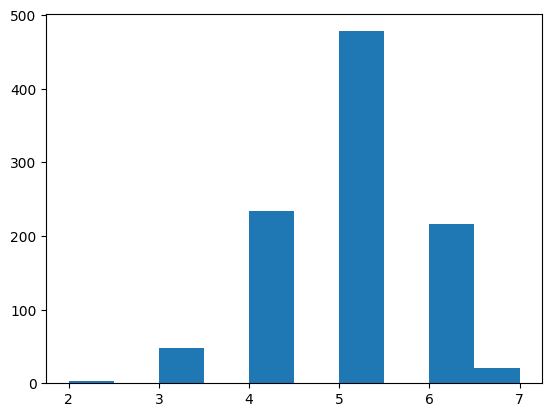

In [65]:

import matplotlib.pyplot as plt
scores = [game.play()[0] for _ in tqdm(range(1000))]
print(sum(scores) / len(scores))

plt.hist(scores)
plt.show()

5.01